In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
import logging
from gru import GRUModelHyperparameters, TrainingConfig # Import the dataclasses
import gru
from data_prep import (
    DataInputConfig,
    TransformationConfig,
    FeatureEngineeringConfig,
    ScalingConfig,
    SequenceConfig,
    prepare_weather_data
)
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [2]:
df = pd.read_csv('solar_weather.csv')
df

,Time,Energy delta[Wh],GHI,temp,pressure,humidity,wind_speed,rain_1h,snow_1h,clouds_all,isSun,sunlightTime,dayLength,SunlightTime/daylength,weather_type,hour,month
0,2017-01-01 00:00:00,0,0.0,1.6,1021,100,4.9,0.0,0.0,100,0,0,450,0.00,4,0,1
1,2017-01-01 00:15:00,0,0.0,1.6,1021,100,4.9,0.0,0.0,100,0,0,450,0.00,4,0,1
2,2017-01-01 00:30:00,0,0.0,1.6,1021,100,4.9,0.0,0.0,100,0,0,450,0.00,4,0,1
3,2017-01-01 00:45:00,0,0.0,1.6,1021,100,4.9,0.0,0.0,100,0,0,450,0.00,4,0,1
4,2017-01-01 01:00:00,0,0.0,1.7,1020,100,5.2,0.0,0.0,100,0,0,450,0.00,4,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
196771,2022-08-31 16:45:00,118,23.7,18.6,1023,57,3.8,0.0,0.0,52,1,780,825,0.95,3,16,8
196772,2022-08-31 17:00:00,82,15.6,18.5,1023,61,4.2,0.0,0.0,60,1,795,825,0.96,3,17,8
196773,2022-08-31 17:15:00,51,8.0,18.5,1023,61,4.2,0.0,0.0,60,1,810,825,0.98,3,17,8
196774,2022-08-31 17:30:00,24,2.1,18.5,1023,61,4.2,0.0,0.0,60,1,825,825,1.00,3,17,8


In [3]:
target_col_original = 'GHI' 

input_cfg = DataInputConfig(
    target_col_original_name=target_col_original
)

transform_cfg = TransformationConfig(
    use_log_transform=False, 
    use_power_transform=True, 
    use_piecewise_transform_target=False, 
    min_target_threshold_initial=None, 
    clip_original_target_before_power_transform=False, 
    original_target_clip_lower_percentile=10.0, 
    original_target_clip_upper_percentile=90.0, 
    min_radiation_floor_before_power_transform=0.0, 
    min_radiation_for_log=0.001, 
    clip_log_transformed_target=True, 
    log_clip_lower_percentile=1.0, 
    log_clip_upper_percentile=99.0 
)

feature_cfg = FeatureEngineeringConfig(
    use_solar_elevation_proxy=True, 
    feature_selection_mode='basic' 
   
)

scaling_cfg = ScalingConfig(
    standardize_features=False 
)

sequence_cfg = SequenceConfig(
    window_size=24, 
    test_size=0.15, 
    val_size_from_train_val=0.25 / (1.0 - 0.15) if (1.0 - 0.15) > 0 else 0.25
)

In [4]:
try:
    X_train, X_val, X_test, y_train, y_val, y_test, \
    scalers, feature_cols, full_transform_details = prepare_weather_data(
        df_input=df,
        input_cfg=input_cfg,
        transform_cfg=transform_cfg,
        feature_cfg=feature_cfg,
        scaling_cfg=scaling_cfg,
        sequence_cfg=sequence_cfg
    )

    logging.info("Data preparation successful using v2.")
    logging.info(f"X_train shape: {X_train.shape}, feature_cols: {feature_cols}")
    logging.info(f"Full transform details: {full_transform_details}")

except Exception as e:
    logging.error(f"Error during data preparation: {e}", exc_info=True)

2025-05-27 17:16:02,839 - INFO - Starting weather data preparation pipeline v2.
2025-05-27 17:16:02,849 - INFO - Applied column renames: {'GHI': 'Radiation', 'temp': 'Temperature', 'pressure': 'Pressure', 'humidity': 'Humidity', 'wind_speed': 'WindSpeed', 'clouds_all': 'Cloudcover', 'rain_1h': 'Rain', 'snow_1h': 'Snow', 'weather_type': 'WeatherType', 'Time': 'Timestamp', 'hour': 'hour', 'month': 'month', 'dayLength': 'dayLength', 'isSun': 'isSun', 'SunlightTime/daylength': 'SunlightTime/daylength'}
2025-05-27 17:16:02,905 - INFO - Sorted DataFrame by 'Timestamp'.
2025-05-27 17:16:02,989 - INFO - Engineered 'SolarElevation' feature.
2025-05-27 17:16:03,002 - INFO - Applying Yeo-Johnson Power Transform to 'Radiation'.
2025-05-27 17:16:03,074 - INFO - Engineered 'Radiation_is_low' feature with threshold -0.0000 (based on 'Radiation_yj').
2025-05-27 17:16:03,074 - INFO - Including low target indicator 'Radiation_is_low' in features.
2025-05-27 17:16:03,074 - INFO - Final selected features 

In [15]:

input_dim = len(feature_cols)  # Number of features
hidden_dim = 64
num_layers = 2
output_dim = 1  # Dimension of output
dropout_prob = 0.3

# Create ModelHyperparameters instance
model_params = GRUModelHyperparameters(
    input_dim=input_dim,
    hidden_dim=hidden_dim,
    num_layers=num_layers,
    output_dim=output_dim,
    dropout_prob=dropout_prob
)


learning_rate_val = 0.00015
epochs_val = 100
batch_size_val = 32
patience_val = 30
scheduler_type_val = "cosine"
weight_decay_val = 0.0 
clip_grad_norm_val = 1.0
loss_type_val = 'mse'
mse_weight_val = 0.7
mape_weight_val = 0.3 
value_multiplier_val = 0.1

# Create TrainingConfig instance
train_cfg = TrainingConfig(
    epochs=epochs_val,
    batch_size=batch_size_val,
    learning_rate=learning_rate_val,
    patience=patience_val,
    scheduler_type=scheduler_type_val,
    weight_decay=weight_decay_val,
    clip_grad_norm=clip_grad_norm_val,
    loss_type=loss_type_val,
    
)



In [16]:
# Initialize model
device = torch.device('mps' if torch.backends.mps.is_available() else 'cuda' if torch.cuda.is_available() else 'cpu') # More robust device selection

# Use the model_params dataclass for instantiation
model = gru.WeatherGRU(model_params=model_params).to(device)

In [7]:

model.transform_info = full_transform_details

# Train the model using the train_cfg dataclass
model.fit(
    X_train, y_train, X_val, y_val,
    train_config=train_cfg, # Pass the TrainingConfig instance
    device=device
)

2025-05-27 17:16:27,212 - INFO - GRU Training started. Device: mps, Config: TrainingConfig(epochs=100, batch_size=32, learning_rate=0.00015, patience=30, factor=0.5, min_lr=1e-06, weight_decay=0.0, clip_grad_norm=1.0, scheduler_type='cosine', T_max_cosine=None, loss_type='mse')
2025-05-27 17:19:51,583 - INFO - GRU Epoch 1/100 - TrainLoss: 0.1320 - ValLoss: 0.0688 | Scaled Metrics: ValRMSE: 0.2622, ValR²: 0.9323, ValCappedMAPE: 17.90%, ValMAE: 0.1356
2025-05-27 17:23:24,780 - INFO - GRU Epoch 2/100 - TrainLoss: 0.0690 - ValLoss: 0.0499 | Scaled Metrics: ValRMSE: 0.2233, ValR²: 0.9509, ValCappedMAPE: 15.28%, ValMAE: 0.1096
2025-05-27 17:26:43,374 - INFO - GRU Epoch 3/100 - TrainLoss: 0.0539 - ValLoss: 0.0373 | Scaled Metrics: ValRMSE: 0.1930, ValR²: 0.9633, ValCappedMAPE: 15.08%, ValMAE: 0.1042
2025-05-27 17:29:59,475 - INFO - GRU Epoch 4/100 - TrainLoss: 0.0449 - ValLoss: 0.0310 | Scaled Metrics: ValRMSE: 0.1762, ValR²: 0.9694, ValCappedMAPE: 13.44%, ValMAE: 0.0902
2025-05-27 17:33:17,0

WeatherGRU(
  (gru): GRU(10, 64, num_layers=2, batch_first=True, dropout=0.3)
  (fc): Linear(in_features=64, out_features=1, bias=True)
  (dropout_fc): Dropout(p=0.3, inplace=False)
)

In [17]:
# Visualize training metrics
fig = model.plot_training_history()
plt.show()
model.transform_info = full_transform_details  # Store the whole transform_info object

2025-05-28 00:00:08,398 - INFO - No GRU training history.


In [20]:
logging.info("Evaluating model on test data...")
try:
    # Evaluate on test data using the refactored method signature
    scaled_preds, scaled_actuals, original_preds, original_actuals, metrics_dict = model.evaluate(
        X_test_data=X_test,
        y_test_data=y_test,
        device=device,  # Pass the device
        target_scaler_object=scalers.get(full_transform_details.get('target_scaler_name')), # Get the specific target scaler
        transform_info_dict=full_transform_details, # This should be the output from data_prep
        scalers_dict=scalers  # Pass the whole scalers dictionary
    )

    # Access metrics directly from the returned dictionary
    if original_preds is not None and original_actuals is not None:
        logging.info(f"Test RMSE (original scale from metrics_dict): {metrics_dict.get('rmse', 'N/A'):.4f}")
        logging.info(f"Test MAE (original scale from metrics_dict): {metrics_dict.get('mae', 'N/A'):.4f}")
        logging.info(f"Test Capped MAPE (original scale from metrics_dict): {metrics_dict.get('mape_capped', 'N/A'):.2f}%")
        logging.info(f"Test R² (original scale from metrics_dict): {metrics_dict.get('r2', 'N/A'):.4f}")
    else:
        logging.warning("Original scale predictions/actuals were not generated, cannot report original scale metrics here.")

    logging.info(f"All scaled metrics: "
                 f"RMSE={metrics_dict.get('scaled_rmse', 'N/A'):.4f}, "
                 f"MAE={metrics_dict.get('scaled_mae', 'N/A'):.4f}, "
                 f"Capped MAPE={metrics_dict.get('scaled_mape_capped', 'N/A'):.2f}% "
                 f"R²={metrics_dict.get('scaled_r2', 'N/A'):.4f}")

except Exception as e:
    logging.error(f"Error during model evaluation: {e}", exc_info=True)

2025-05-28 00:01:38,498 - INFO - Evaluating model on test data...
2025-05-28 00:01:39,520 - INFO - 
--- GRU Scaled Metrics ---
2025-05-28 00:01:39,528 - INFO - RMSE (scaled): 0.9949, R² (scaled): 0.0222, MAE (scaled): 0.9467, Capped MAPE (scaled): 97.51%
2025-05-28 00:01:39,528 - INFO - 
--- GRU Original Scale Metrics ---
2025-05-28 00:01:39,532 - INFO - RMSE (original): 1.3312, R² (original): 0.0222, MAE (original): 1.2667, Capped MAPE (original): 72.72%
2025-05-28 00:01:39,533 - INFO - Test RMSE (original scale from metrics_dict): 1.3312
2025-05-28 00:01:39,533 - INFO - Test MAE (original scale from metrics_dict): 1.2667
2025-05-28 00:01:39,534 - INFO - Test Capped MAPE (original scale from metrics_dict): 72.72%
2025-05-28 00:01:39,534 - INFO - Test R² (original scale from metrics_dict): 0.0222
2025-05-28 00:01:39,534 - INFO - All scaled metrics: RMSE=0.9949, MAE=0.9467, Capped MAPE=97.51% R²=0.0222


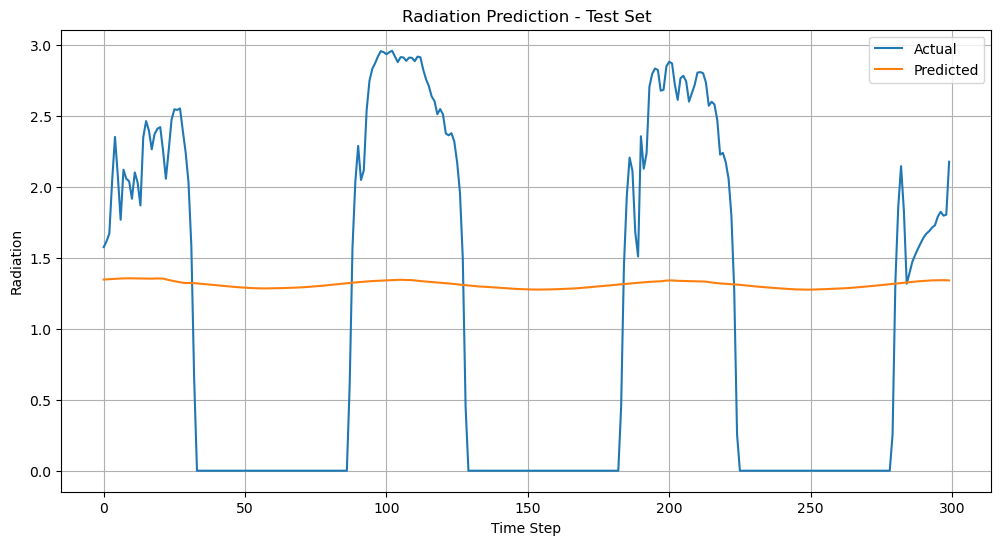

In [24]:


plt.figure(figsize=(12, 6))
plt.plot(original_actuals[:300], label='Actual')
plt.plot(original_preds[:300], label='Predicted')
plt.title('Radiation Prediction - Test Set')
plt.xlabel('Time Step')
plt.ylabel('Radiation')
plt.legend()
plt.grid(True)
plt.show()

In [25]:
gru.plot_prediction_with_uncertainty(X_test, y_test, 
                                         mc_samples = 30, 
                                         target_scaler = scalers["Radiation_log"],
                                         transform_info=full_transform_details, 
                                         device= "mps", 
                                         alpha = 0.05,
                                         max_samples_to_plot= 5)

AttributeError: module 'gru' has no attribute 'plot_prediction_with_uncertainty'

In [ ]:
fig =model.plot_forecast(X_test, y_test, forecast_steps=48, target_scaler=scalers["Radiation_log"],
                     figsize=(15, 8), device="mps", plot_samples=1, offset=0)
plt.show()

In [18]:
model.save('gru_model.pt')

2025-05-28 00:00:21,647 - INFO - GRU Model saved to gru_model.pt
